## Stable Diffusion Lora Finetuning
### Setup

In [1]:
!pip --quiet install diffusers peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 98.7 MB/s eta 0:00:00


### 필요한 라이브러리 로드

In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torchvision import transforms
from transformers import CLIPTextModel, CLIPTokenizer, AutoProcessor, AutoModel
from diffusers import AutoencoderKL, UNet2DConditionModel, DDPMScheduler
from diffusers.optimization import get_scheduler
from diffusers.utils import convert_state_dict_to_diffusers
from diffusers.training_utils import cast_training_params

from peft import LoraConfig
from peft.utils import get_peft_model_state_dict

from tqdm import tqdm

from PIL import Image

from diffusers import StableDiffusionPipeline

import shutil

from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


### 데이터 전처리

In [3]:
root_dir = "/content/gdrive/MyDrive/Colab Notebooks/data/fairyTale"

datasets = pd.read_csv(f"{root_dir}/fairyTale.csv")
datasets['image'] = datasets['image'].apply(lambda x: f"{root_dir}/images/{x}")
datasets.head()

,image,text
0,/content/gdrive/MyDrive/Colab Notebooks/data/f...,불을 피우는 잔에게 아버지가 감자 자루를 숨기라고 말씀하십니다.
1,/content/gdrive/MyDrive/Colab Notebooks/data/f...,"다나가 색연필로 그림을 그리고, 도화지에 글자를 쓰고 있습니다."
2,/content/gdrive/MyDrive/Colab Notebooks/data/f...,바다 옆 모래밭에서 바닷말에 뒤덮여 있는 딱딱이는 정신을 차리고 있습니다.
3,/content/gdrive/MyDrive/Colab Notebooks/data/f...,깨우지도 않았는데 벌떡 일어난 꽃님이를 본 엄마가 놀란 표정으로 서 있습니다.
4,/content/gdrive/MyDrive/Colab Notebooks/data/f...,아이들이 종이컵으로 청진기를 만들어서 심장 부분에 대고 심장 소리를 듣습니다.


In [4]:
PRE_TRAINED_MODEL_NAME="Bingsu/my-korean-stable-diffusion-v1-5"

noise_scheduler = DDPMScheduler.from_pretrained(
    PRE_TRAINED_MODEL_NAME,
    subfolder="scheduler"
)

tokenizer = CLIPTokenizer.from_pretrained(
    PRE_TRAINED_MODEL_NAME,
    subfolder="tokenizer"
)

text_encoder = CLIPTextModel.from_pretrained(
    PRE_TRAINED_MODEL_NAME,
    subfolder="text_encoder"
)

vae = AutoencoderKL.from_pretrained(
    PRE_TRAINED_MODEL_NAME,
    subfolder="vae"
)

unet = UNet2DConditionModel.from_pretrained(
    PRE_TRAINED_MODEL_NAME,
    subfolder="unet"
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

text_encoder/pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/576 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

In [5]:
IMG_SIZE = 512
CENTER_CROP = True
RANDOM_FLIP = True
BATCH_SIZE = 4
NUM_WORKERS = 4

In [6]:
train_transforms = transforms.Compose(
    [
        transforms.Resize(IMG_SIZE, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.CenterCrop(IMG_SIZE) if CENTER_CROP else transforms.RandomCrop(IMG_SIZE),
        transforms.RandomHorizontalFlip() if RANDOM_FLIP else transforms.Lambda(lambda x: x),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]), # (0,1)->(-1,1)
    ]
)

In [7]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, tokenizer, transforms):
        self.data = data
        self.tokenizer = tokenizer
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def tokenize_captions(self, caption, is_train=True):
        if isinstance(caption, str):
            text = caption
        elif isinstance(caption, (list, np.ndarray)):
            text = random.choice(caption) if is_train else caption[0]
        else:
            raise ValueError("올바르지 않은 데이터 타입입니다. 데이터 타입이 str 또는 list, ndarray 인지 확인해주세요.")

        inputs = tokenizer(
            text,
            max_length=tokenizer.model_max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        return inputs.input_ids.squeeze(0)

    def __getitem__(self, idx):
        image = Image.open(self.data['image'][idx])

        rgb = image.convert('RGB')
        pixel_values = self.transforms(rgb)

        input_ids = self.tokenize_captions(self.data['text'][idx])

        return {"pixel_values": pixel_values, "input_ids": input_ids}

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])

    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

    input_ids = torch.stack([example["input_ids"] for example in examples])

    return {"pixel_values": pixel_values, "input_ids": input_ids}

custom_DS = CustomDataset(datasets, tokenizer, train_transforms)

train_DL = torch.utils.data.DataLoader(custom_DS, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

### Stable Diffusiong 모델 학습

In [8]:
weight_dtype = torch.float16

unet.requires_grad_(False)
vae.requires_grad_(False)
text_encoder.requires_grad_(False);

In [9]:
LORA_RANK = 4

for param in unet.parameters():
    param.requires_grad_(False)

unet_lora_config = LoraConfig(
    r=LORA_RANK,
    lora_alpha=LORA_RANK,
    init_lora_weights="gaussian",
    target_modules=["to_k", "to_q", "to_v", "to_out.0"],
)

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

text_encoder.to(device)
vae.to(device)
unet.to(device)

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_fe

In [11]:
unet.add_adapter(unet_lora_config)

if weight_dtype == torch.float16:
    cast_training_params(unet, dtype=torch.float32)

lora_layers = filter(lambda p: p.requires_grad, unet.parameters())

In [12]:
EPOCHS = 5
LEARNING_RATE = 1e-04

optimizer = torch.optim.AdamW(
        lora_layers,
        lr=LEARNING_RATE,
    )

In [13]:
lr_scheduler = get_scheduler(
        'linear',
        optimizer=optimizer,
        num_warmup_steps=500,
        num_training_steps=EPOCHS * len(datasets)
    )

In [14]:
noise_scheduler.config.prediction_type, vae.config.scaling_factor

('epsilon', 0.18215)

In [15]:
use_amp = True
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
prediction_type = None

train_losses = []

for epoch in range(EPOCHS):
    for step, batch in enumerate(tqdm(train_DL)):
        with torch.autocast(device_type=device, dtype=weight_dtype, enabled=use_amp):
            latents = vae.encode(
                batch["pixel_values"].to(device)
            ).latent_dist.sample()
            latents = latents * vae.config.scaling_factor

            noise = torch.randn_like(latents)

            bsz = latents.shape[0]

            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device)
            timesteps = timesteps.long()

            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

            encoder_hidden_states = text_encoder(batch["input_ids"].to(device) )[0]

            if prediction_type is not None:
                noise_scheduler.register_to_config(prediction_type=prediction_type)

            if noise_scheduler.config.prediction_type == "epsilon":
                target = noise
            elif noise_scheduler.config.prediction_type == "v_prediction":
                target = noise_scheduler.get_velocity(latents, noise, timesteps)
            else:
                raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

            model_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

            loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")


        with torch.no_grad():
            train_losses.append(loss.item())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        lr_scheduler.step()
        optimizer.zero_grad()

    # print loss
    avg_loss = sum(train_losses[-100:])/100
    print(f'Finished epoch {epoch+1}. Average of the last 100 loss values: {avg_loss:05f}')


/tmp/ipython-input-2073170751.py:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
100%|██████████| 3239/3239 [1:30:17<00:00,  1.67s/it]


Finished epoch 1. Average of the last 100 loss values: 0.132378


100%|██████████| 3239/3239 [25:11<00:00,  2.14it/s]


Finished epoch 2. Average of the last 100 loss values: 0.122638


100%|██████████| 3239/3239 [25:09<00:00,  2.15it/s]


Finished epoch 3. Average of the last 100 loss values: 0.127706


100%|██████████| 3239/3239 [25:36<00:00,  2.11it/s]


Finished epoch 4. Average of the last 100 loss values: 0.138624


100%|██████████| 3239/3239 [25:35<00:00,  2.11it/s]

Finished epoch 5. Average of the last 100 loss values: 0.132718


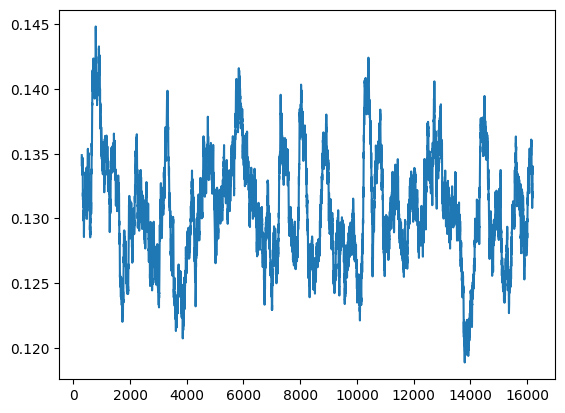

In [16]:
losses_sr = pd.Series(train_losses)
loss_mv = losses_sr.rolling(window=300).mean()

plt.plot(loss_mv)

In [17]:
pipeline = StableDiffusionPipeline.from_pretrained(
    PRE_TRAINED_MODEL_NAME,
    text_encoder=text_encoder,
    vae=vae,
    unet=unet,
)

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 10 files:   0%|          | 0/10 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

safety_checker/pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [18]:
pipeline.to(device)

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.34.0",
  "_name_or_path": "Bingsu/my-korean-stable-diffusion-v1-5",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

Token indices sequence length is longer than the specified maximum sequence length for this model (78 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["'"]


  0%|          | 0/20 [00:00<?, ?it/s]

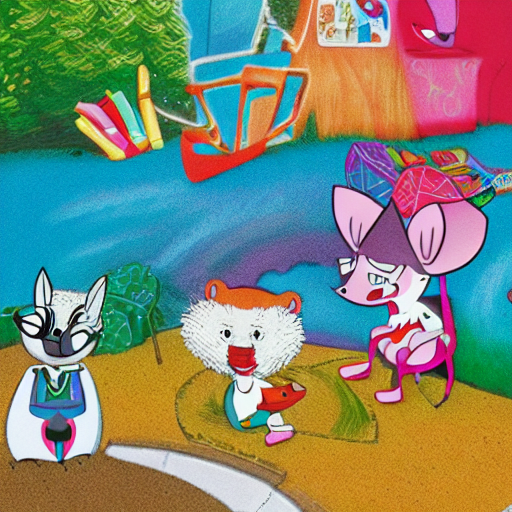

In [19]:
lora_scale = 0.9
pipeline_output = pipeline(
    prompt=["맞아요! 다나는 텔레비전을 볼 때 광고를 보는 게 제일 좋아요. 재미있는 노랫말이 라랄랄라 신이 나게 해줘요. 또, 다나는 물건마다 별명 붙이기를 좋아해요. 책은 '글자들의 놀이터' 색연필은 '무지개들의 집' 흰 도화지는 '말 없는 친구' 복슬복슬 강아지 짱이는 '굴러다니는 털 뭉치'"],
    num_inference_steps=20,
    cross_attention_kwargs={"scale": lora_scale},
    generator=torch.manual_seed(101)
)
pipeline_output.images[0]

In [20]:
unet_lora_state_dict = convert_state_dict_to_diffusers(get_peft_model_state_dict(unet))

In [21]:
list(unet_lora_state_dict.keys())[:5]

['down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q.lora.down.weight',
 'down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q.lora.up.weight',
 'down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_k.lora.down.weight',
 'down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_k.lora.up.weight',
 'down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_v.lora.down.weight']

In [22]:
StableDiffusionPipeline.save_lora_weights(
    save_directory="./lora_finetuning_weights",
    unet_lora_layers=unet_lora_state_dict,
    safe_serialization=True,
)